""" MNIST dataset
- データセットの種類: クラス分類
- 画像枚数(学習用): 60000枚
- 画像枚数(テスト用): 10000枚
- 画像サイズ: 28 * 28のグレースケール画像
"""

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [14]:
# データの前処理
transform = transforms.Compose([
  transforms.Grayscale(num_output_channels=3),  # 1チャンネルを3チャンネルに変換
  transforms.Resize((224, 224)),  # ViTモデルは大きな画像が必要
  transforms.ToTensor()
  transforms.Normalize((0.5,), (0.5,))
])

In [15]:
# MNISTデータセットのダウンロードとロード
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [16]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [17]:
# データローダーの作成
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Active ShowImages


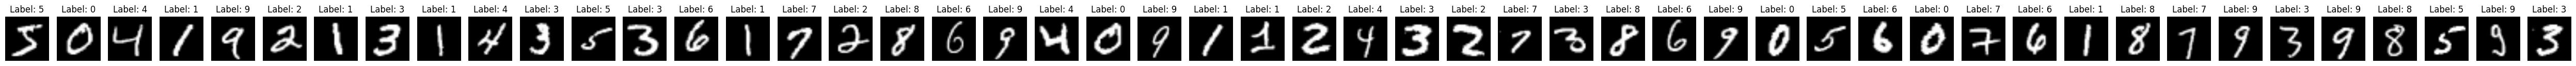

In [18]:
from util.show_images import ShowImages
# ShowImagesクラスのインスタンスを作成
show_images_instance = ShowImages()

# testメソッドを呼び出す
show_images_instance.show_images(dataset=train_dataset, num_images_to_display=50)

In [ ]:
import torch.nn as nn
from torchvision.models import VisionTransformer, vit_b_16
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Vision Transformerモデルの定義
class ViT_MNIST(nn.Module):
    def __init__(self, vit_model):
        super(ViT_MNIST, self).__init__()
        self.features = vit_model.features
        self.avgpool = vit_model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(768, 10),  # MNISTのクラス数は10
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# ViTモデルのインスタンス化
vit_model = vit_b_16(pretrained=True)  # 事前学習済みの重みを使用する場合
# vit_model = vit_b_16()  # 事前学習済みの重みを使用しない場合

# ViT_MNISTモデルのインスタンス化
model = ViT_MNIST(vit_model).to(device)

# 損失関数と最適化アルゴリズムの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# トレーニング
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
    

print("Finished Training")

# テスト
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total}%")